# The purpose of this notebook is to create a monte carlo simulation of blackjack

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Custom Modules.
from Game import Game
from Player import Player

# Custom Functions.
from RecursePlayer import recursePlayer,dealHouse,getReward,getValue
from Q_Learning import initQ,learnPolicy,evaluatePolicy,getBestAction
from Utils import dfBestMove

# Rewards Distribution

Given random gameplay, what are the expected reward for each state-action pair?

### Here, I can specifically state which combinations I want played. However, right now, I assume plentiful cards. Will not serve as optimal policy evaluation, but rather expected rewards given a state - action pair.

So, every combination is possible (hardcoded in), and the next card drawn is uniformly, with replacement. 

Might introduce some bias. Imagine player shows [2,2], the odds of them drawing another 2 should be lower, but this method does not say so.

I use discounted rewards. For example:
- Player shows 5, they hit to get 9, hit to get 12, hit to get 20, stay, and ends up winning the hand.
- I'm most interested in the move taken when player has 20.
- How I handle this is by using the gamma hyperparameter and discounting earlier moves more

Initialize the simulation

In [2]:
blackjack = Game(Player)
cardMap = blackjack.cardMap
cardValues = blackjack.cardValues
allCards = list(cardMap.values())

moves = ['stay','hit','double','surrender','split']

pairsSplit = {(c,c):i for i,c in enumerate(allCards)}
pairsSplit = {}
count = 0
for c in allCards :
    pairsSplit[(c,c)] = count
    if c not in [10,'J','Q'] :
        count += 1
    

# initialize arrays for totals + rewards
# dimensions are (m,a,p,h)
# - m : # of possible moves
# - a : useable ace or not
# - p : # of possible totals (includes 0,1,2,3 for simplicity), PLUS # of pairs
# - h : # of possible house face-up card (includes 0,1,2,3 for simplicity)

totals = np.zeros((len(moves),2,21+1+len(pairsSplit)-3,11+1))
rewards = np.zeros((len(moves),2,21+1+len(pairsSplit)-3,11+1))

gamma = .7

nTrials = 2000

Run the trail

In [6]:
for n in range(nTrials) :
    print('{} of {}'.format(n,nTrials),end='\r')
    for i in range(len(allCards)) :
        for j in range(i,len(allCards)) :
            cards = [allCards[i],allCards[j]]
            for h in range(len(allCards)) :
                houseCards,val,houseShow = dealHouse(allCards[h],cardMap,cardValues)
                seriesOut = recursePlayer(cards,allCards[h],cardMap,cardValues)

                for r in seriesOut :
                    if len(r)==0 :
                        totals[0,0,21,houseShow] += 1
                        rewards[0,0,21,houseShow] += 1.5
                        continue
                    reward = getReward(r,val)
                    
                    # I can discount earlier moves (hence reversing the order of moves)
                    # to more accurately reflect the benefit of hitting on smaller player cards shown.
                    for g,(playerShow,move,useableAce,pairSplit,nextVal) in enumerate(r[::-1]) :
                        indPlayer = playerShow
                        if pairSplit :
                            indPlayer = 22 + pairsSplit[tuple(pairSplit)]
                        totals[moves.index(move),int(useableAce),indPlayer,houseShow] += 1   
                        rewards[moves.index(move),int(useableAce),indPlayer,houseShow] += reward*gamma**g
            
            
normalized = np.zeros(totals.shape)
for m in range(len(moves)) :
    for i in [0,1] :
        # prevent division by zero, clip totals (shouldn't happen if # iterations is high enough)
        normalized[m][i] = rewards[m][i] / np.clip(totals[m][i],a_min=1,a_max=None)
            
            
        

In [3]:
#np.save('normalized.npy',normalized)
normalized = np.load('normalized.npy')

In [4]:
noAce,useableAce,canSplit = dfBestMove(normalized,moves,pairsSplit,colorBox=True)

In [5]:
noAce

,2,3,4,5,6,7,8,9,10,11
5,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi
6,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi
7,Hi,Hi,Hi,Hi,Do,Hi,Hi,Hi,Hi,Hi
8,Hi,Do,Do,Do,Do,Hi,Hi,Hi,Hi,Hi
9,Do,Do,Do,Do,Do,Do,Do,Hi,Hi,Hi
10,Do,Do,Do,Do,Do,Do,Do,Do,Do,Hi
11,Do,Do,Do,Do,Do,Do,Do,Do,Do,Hi
12,St,St,St,St,St,Hi,Hi,Hi,Hi,Hi
13,St,St,St,St,St,Hi,Hi,Hi,Hi,Hi
14,St,St,St,St,St,Hi,Hi,Hi,Hi,Su


In [6]:
useableAce

,2,3,4,5,6,7,8,9,10,11
13,Do,Do,Do,Do,Do,Hi,Hi,Hi,Hi,Hi
14,Hi,Do,Do,Do,Do,Hi,Hi,Hi,Hi,Hi
15,Do,Do,Do,Do,Do,Hi,Hi,Hi,Hi,Hi
16,Do,Do,Do,Do,Do,Hi,Hi,Hi,Hi,Hi
17,Do,Do,Do,Do,Do,Do,Hi,Hi,Hi,Hi
18,St,Do,Do,Do,Do,St,St,St,St,Hi
19,St,St,St,St,St,St,St,St,St,St
20,St,St,St,St,St,St,St,St,St,St
21,St,St,St,St,St,St,St,St,St,St


In [7]:
canSplit

,2,3,4,5,6,7,8,9,10,11
"(2, 2)",Sp,Sp,Sp,Sp,Sp,Sp,Sp,Hi,Hi,Hi
"(3, 3)",Sp,Sp,Sp,Sp,Sp,Sp,Sp,Sp,Hi,Hi
"(4, 4)",Hi,Do,Do,Do,Do,Hi,Hi,Hi,Hi,Hi
"(5, 5)",Do,Do,Do,Do,Do,Do,Do,Do,Do,Hi
"(6, 6)",Sp,Sp,Sp,St,St,Sp,Sp,Sp,Sp,Sp
"(7, 7)",Sp,Sp,Sp,St,St,Sp,Sp,Sp,Sp,Sp
"(8, 8)",Sp,Sp,Sp,St,St,Sp,Sp,Sp,Sp,Sp
"(9, 9)",St,St,St,St,St,St,St,St,St,St
"(10, 10)",St,St,St,St,St,St,St,St,St,St
"('A', 'A')",Sp,Sp,Do,Do,Do,Sp,Sp,Sp,Sp,Sp


# Policy Generation (Control)

Can I learn an optimal policy using Monte Carlo methods?
- Greedy Algorithm
- Epsilon-Greedy Algorithm
- Thompson Sampling methods.

# Simulate game play, gather totals and rewards, normalized rewards, and display best option.

In [16]:
def initQ(moves,allCards) :
    
    movesNoSplit = [m for m in moves if m!='split']

    Q = {
        'canSplit':{},
        'noSplit':{}
    }
    
    for p in range(5,22) :
        
        for h in range(2,12) :
            if (21 > p > 11) :
                for a in [True,False] :
                    Q['noSplit'][(p,h,a)] = {m:0 for m in movesNoSplit}
            else :
                Q['noSplit'][(p,h,False)] = {m:0 for m in movesNoSplit}
    
    for c in allCards :
        if c in ['J','Q','K'] :
            continue
        for h in range(2,12) :
            a = False if c!='A' else True
            Q['canSplit'][(c,h,a)] = {m:0 for m in moves}

    return Q

def getBestAction(state,policy,epsilon) :
    
    n = np.random.rand()
    if n < epsilon :
        move = np.random.choice(policy)
    else :
        qDict = {k:v for k,v in state.items() if k in policy}
        bestMove = [k for k,v in qDict.items() if v==max(list(qDict.values()))]
        move = np.random.choice(bestMove)
    
    return move

def genEpisode(blackjack,iPlayer,Q,epsilon) :
    
    '''
    Inputs :
        - blackjack : module of blackjack gameplay (will contain the state)
        - Q : q values for the state-action pairs
        - epsilon : e-greedy hyperparameter. Explore vs. exploit.
        
    Outputs : 
        - Updated blackjack module
    
    Returns :
        - s_a_pairs : state-action pairs
    '''
    
    s_a_pairs = [[]]
    
    player = blackjack.players[iPlayer]
    houseShow = blackjack.getHouseShow(showValue=True)

    while not player.isDone() :

        playerShow,canSplit,useableAce,card1 = player.getValue()
        nHand = player._getCurHand()

        policy = player.getValidMoves(houseShow)
        policy = [p for p in policy if p!='insurance']
        
        if canSplit :
            move = getBestAction(Q['canSplit'][(card1,houseShow,useableAce)],policy,epsilon)
        else :
            move = getBestAction(Q['noSplit'][(playerShow,houseShow,useableAce)],policy,epsilon)

        s_a_pairs[nHand].append((playerShow,houseShow,useableAce,canSplit,card1,move))

        if move == 'split' :
            s_a_pairs.append(s_a_pairs[nHand].copy())

        blackjack.stepPlayer(player,move)
        
    return s_a_pairs

def learnPolicy(blackjack,Q,nPlayers,epsilon,gamma,lr) :
    
    '''
    epsilon : e-greedy hyperparameter
    gamma : decay factor, which I use to discount rewards for earlier moves in a round
    lr : learning rate to update Q function
    
    returns :
        learned Q function
    '''

    s_a_pairs = []

    for i in range(nPlayers) :

        s_a_pairs.append(genEpisode(blackjack,i,Q,epsilon))

    blackjack.stepHouse() #play the house complete hand.

    _,playerWinnings = blackjack.getResults()


    for i,w in enumerate(playerWinnings) :

        j = 0
        hand = 0
        while hand < len(s_a_pairs[i]) :
            
            # current state-action pair 
            # (player,house,useableAce,canSplit,card_1,move)
            p,h,a,s,c1,m = s_a_pairs[i][hand][j]
            if s :
                oldQ = Q['canSplit'][(c1,h,a)][m] # Q value for current state-action pair if canSplit
            else :
                oldQ = Q['noSplit'][(p,h,a)][m] # Q value for current state-action pair if cannotSplit
            
            r = w
            maxQ_p = 0
            if (j+1) < len(s_a_pairs[i][hand]) :
                p_p,h_p,a_p,s_p,c1_p,_ = s_a_pairs[i][hand][j+1]
                # get maximum Q value for s`
                if s_p:
                    maxQ_p = max(Q['canSplit'][(c1_p,h_p,a_p)].values())
                else :
                    maxQ_p = max(Q['noSplit'][(p_p,h_p,a_p)].values())
                r = 0
            
            if s :
                Q['canSplit'][(c1,h,a)][m] = oldQ + lr*(r + gamma*maxQ_p - oldQ)
            else :
                Q['noSplit'][(p,h,a)][m] = oldQ + lr*(r + gamma*maxQ_p - oldQ)
            
            if j < len(s_a_pairs[i][hand])-1 :
                j += 1 # move to next player
            else : 
                hand += 1 # move to next hand for a player
                j = 0

def evaluatePolicy(blackjack,Q,wagers,nRounds) :
    
    rewards = [[] for _ in wagers]
        
    for r in range(nRounds) :
        blackjack.initRound(wagers) # must call this before dealing a round

        blackjack.dealInit() # initial deal, before players decide what to do.
        houseShow = blackjack.getHouseShow(showValue=True)  

        for i,player in enumerate(blackjack.players) :

            while not player.isDone() :
                
                playerShow,canSplit,useableAce,card1 = player.getValue()
                policy = player.getValidMoves(houseShow)
                policy = [p for p in policy if p!='insurance']
                if canSplit:
                    move = getBestAction(Q['canSplit'][(card1,houseShow,useableAce)],policy,-1)
                else :
                    move = getBestAction(Q['noSplit'][(playerShow,houseShow,useableAce)],policy,-1)

                blackjack.stepPlayer(player,move)

        blackjack.stepHouse() #play the house complete hand.

        _,playerWinnings = blackjack.getResults()


        for i,w in enumerate(playerWinnings) :

            rewards[i].append(w)

    return rewards

In [59]:
Q = {
    'name':'e-Greedy Decay 1',
    'epsilon_decay':.001,
    'min_epsilon':.1,
    'evaluation':[]
}

nEpisodes = int(5e6)
nPlayers = 1
gamma = .8
lr = .01
nDecks = 6
ratioPenetrate = 4/6
wagers = [1]*nPlayers

nRoundsEvaluate = 1000

moves = ['stay','hit','split','double','surrender']

earlyStop = True
e = 100 # early stopping criterion
every = 10 # interval to evaluate policy


In [60]:
blackjack = Game(Player,shrinkDeck=True,nDecks=nDecks,ratioPenetrate=ratioPenetrate,verbose=False)
allCards = list(blackjack.cardMap.values())
Q['Q'] = initQ(moves,allCards)

r = 0
counter = 0
minPerformance = -10
while r < nEpisodes :

    blackjack.initRound(wagers)
    houseBlackjack = blackjack.dealInit()
    if blackjack.houseBlackjack :
        continue
    eps = max(Q['min_epsilon'],np.exp(-Q['epsilon_decay']*r)) #exponential decay factor.
    learnPolicy(blackjack,Q['Q'],nPlayers,eps,gamma,lr)

    if not r%every :
        blackjack = Game(Player,shrinkDeck=True,nDecks=nDecks,ratioPenetrate=ratioPenetrate,verbose=False)
        p = np.mean(evaluatePolicy(blackjack,Q['Q'],wagers,nRoundsEvaluate)[-1])
        Q['evaluation'].append(p)

        print('Method {} : {} of {}. EPS : {} Score : {}'.format(Q['name'],r+1,nEpisodes,eps,p))

        if p < minPerformance : 
            counter += 1
        else :
            counter = 0
            bestQ = Q['Q'].copy() #backtracking. This will be used as optimal Q value dict. 
        minPerformance = max(minPerformance,p)

    if (earlyStop) & (counter == e) :

        print('Early Stopping at Round {}.'.format(r))
        break

    r += 1

Method e-Greedy Decay 1 : 1 of 5000000. EPS : 1.0 Score : -0.4725
Method e-Greedy Decay 1 : 11 of 5000000. EPS : 0.9900498337491681 Score : -0.4625
Method e-Greedy Decay 1 : 21 of 5000000. EPS : 0.9801986733067553 Score : -0.448
Method e-Greedy Decay 1 : 31 of 5000000. EPS : 0.9704455335485082 Score : -0.478
Method e-Greedy Decay 1 : 41 of 5000000. EPS : 0.9607894391523232 Score : -0.477
Method e-Greedy Decay 1 : 51 of 5000000. EPS : 0.951229424500714 Score : -0.495
Method e-Greedy Decay 1 : 61 of 5000000. EPS : 0.9417645335842487 Score : -0.428
Method e-Greedy Decay 1 : 71 of 5000000. EPS : 0.9323938199059483 Score : -0.4015
Method e-Greedy Decay 1 : 81 of 5000000. EPS : 0.9231163463866358 Score : -0.5165
Method e-Greedy Decay 1 : 91 of 5000000. EPS : 0.9139311852712282 Score : -0.429
Method e-Greedy Decay 1 : 101 of 5000000. EPS : 0.9048374180359595 Score : -0.398
Method e-Greedy Decay 1 : 111 of 5000000. EPS : 0.8958341352965282 Score : -0.4775
Method e-Greedy Decay 1 : 121 of 50000

Method e-Greedy Decay 1 : 1011 of 5000000. EPS : 0.3642189795715233 Score : -0.282
Method e-Greedy Decay 1 : 1021 of 5000000. EPS : 0.3605949401730783 Score : -0.262
Method e-Greedy Decay 1 : 1031 of 5000000. EPS : 0.3570069605691474 Score : -0.307
Method e-Greedy Decay 1 : 1041 of 5000000. EPS : 0.35345468195878016 Score : -0.234
Method e-Greedy Decay 1 : 1051 of 5000000. EPS : 0.3499377491111553 Score : -0.2395
Method e-Greedy Decay 1 : 1061 of 5000000. EPS : 0.3464558103300574 Score : -0.21
Method e-Greedy Decay 1 : 1071 of 5000000. EPS : 0.34300851741870664 Score : -0.267
Method e-Greedy Decay 1 : 1081 of 5000000. EPS : 0.3395955256449391 Score : -0.2605
Method e-Greedy Decay 1 : 1091 of 5000000. EPS : 0.3362164937067333 Score : -0.247
Method e-Greedy Decay 1 : 1101 of 5000000. EPS : 0.33287108369807955 Score : -0.241
Method e-Greedy Decay 1 : 1111 of 5000000. EPS : 0.32955896107518906 Score : -0.257
Method e-Greedy Decay 1 : 1121 of 5000000. EPS : 0.32627979462303947 Score : -0.21

Method e-Greedy Decay 1 : 1991 of 5000000. EPS : 0.13669542544552385 Score : -0.187
Method e-Greedy Decay 1 : 2001 of 5000000. EPS : 0.1353352832366127 Score : -0.1825
Method e-Greedy Decay 1 : 2011 of 5000000. EPS : 0.13398867466880493 Score : -0.1885
Method e-Greedy Decay 1 : 2021 of 5000000. EPS : 0.13265546508012172 Score : -0.266
Method e-Greedy Decay 1 : 2031 of 5000000. EPS : 0.13133552114849303 Score : -0.168
Method e-Greedy Decay 1 : 2041 of 5000000. EPS : 0.1300287108784259 Score : -0.2585
Method e-Greedy Decay 1 : 2051 of 5000000. EPS : 0.12873490358780423 Score : -0.2215
Method e-Greedy Decay 1 : 2061 of 5000000. EPS : 0.12745396989482075 Score : -0.196
Method e-Greedy Decay 1 : 2071 of 5000000. EPS : 0.12618578170503877 Score : -0.2295
Method e-Greedy Decay 1 : 2081 of 5000000. EPS : 0.12493021219858241 Score : -0.282
Method e-Greedy Decay 1 : 2091 of 5000000. EPS : 0.12368713581745483 Score : -0.1875
Method e-Greedy Decay 1 : 2101 of 5000000. EPS : 0.1224564282529819 Scor

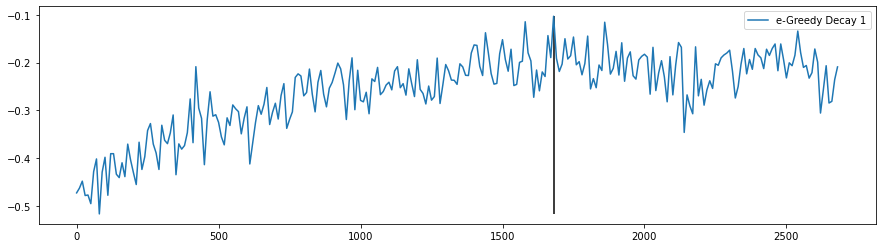

In [61]:
plt.figure(figsize=(15,4))
plt.plot(np.arange(0,len(Q['evaluation']))*every,Q['evaluation'],label=Q['name'])
plt.vlines(x=np.argmax(Q['evaluation'])*every,ymin=min(Q['evaluation']),ymax=max(Q['evaluation']),color='k')

plt.legend()
plt.show()

In [8]:
#np.save('Q',Q[0]['Q'])
Qlearned = np.load('Q.npy',allow_pickle=True).item()

Evaluate new policy, as well as a random one, and a simple one.

Generating Random Rewards...
Generating Learned Rewards...
Generating Meh Rewards...
Done


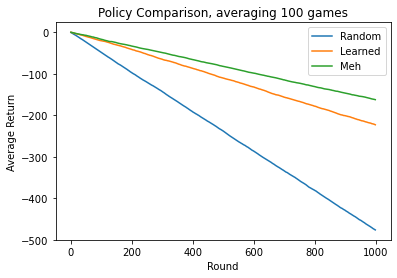

In [76]:
nRoundsEvaluate = 1000

print('Generating Random Rewards...')
randQ = initQ(['stay','hit','split','double','insurance','surrender'],allCards)
blackjack = Game(Player,shrinkDeck=True,nDecks=nDecks,ratioPenetrate=ratioPenetrate,verbose=False)
randomRewards = np.mean([np.cumsum(evaluatePolicy(blackjack,randQ,wagers,nRoundsEvaluate)[0]) for _ in range(100)],axis=0)

print('Generating Learned Rewards...')
blackjack = Game(Player,shrinkDeck=True,nDecks=nDecks,ratioPenetrate=ratioPenetrate,verbose=False)
try : # if Qlearned has been defined, read in from file, else use the Q dict trained in this notebook.
    learnedRewards = np.mean([np.cumsum(evaluatePolicy(blackjack,Qlearned,wagers,nRoundsEvaluate)[0]) for _ in range(100)],axis=0)
except :
    learnedRewards = np.mean([np.cumsum(evaluatePolicy(blackjack,bestQ,wagers,nRoundsEvaluate)[0]) for _ in range(100)],axis=0)

print('Generating Meh Rewards...')
somewhatSmartQ = initQ(['stay','hit','split','double','insurance','surrender'],allCards)
for split,s_pairs in somewhatSmartQ.items() :
    for s,vals in s_pairs.items() :
        p,h,a = s
        if split=='canSplit' :
            if p == 'A' :
                p = 12
            else :
                p = p*2
        if p > 17 :
            vals['stay'] = 1
        else :
            vals['hit'] = 1

blackjack = Game(Player,shrinkDeck=True,nDecks=nDecks,ratioPenetrate=ratioPenetrate,verbose=False)
mehRewards = np.mean([np.cumsum(evaluatePolicy(blackjack,somewhatSmartQ,wagers,nRoundsEvaluate)[0]) for _ in range(100)],axis=0)
print('Done')

plt.title('Policy Comparison, averaging 100 games')
plt.plot(randomRewards,label='Random')
plt.plot(learnedRewards,label='Learned')
plt.plot(mehRewards,label='Meh')
plt.xlabel('Round')
plt.ylabel('Average Return')
plt.legend()
plt.show()

Play a hand according to learned policy.

In [25]:
blackjack = Game(Player,verbose=False)

blackjack.initRound(wagers=[1])
blackjack.dealInit()
player = blackjack.players[0] # only 1 player, so i'll just extract that specific player module.
houseShow = blackjack.getHouseShow(showValue=True)


while not player.isDone() :

    playerShow,useableAce = player.getValue()

    policy = player.getValidMoves(houseShow)
    policy = [p for p in policy if p!='insurance']
    try :
        move = getBestAction(Qlearned[(playerShow,houseShow,useableAce)],policy,-1)
    except :
        move = getBestAction(Q[0]['Q'][(playerShow,houseShow,useableAce)],policy,-1)
    print(player.cards,move)
    
    blackjack.stepPlayer(player,move)
    
blackjack.stepHouse()

print(blackjack.house.cards)
blackjack.getResults()

[[4, 3]] hit
[[4, 3, 3]] hit
[[4, 3, 3, 5]] stay
[['K', 10]]


([['loss']], [-1])